The first latent factor example involves combining forecasts from different models. We have the forecast means and variances from 4 models that were used to predict quarterly US inflation from 1977 to 2014. One simple approach would be to use the 4 forecast means as predictors in a unified model. However, because we know the variance associated with each forecast, we can use a latent factor instead and account for the forecast uncertainty. This example is inspired by Bayesian Predictive Synthesis, which is a sophisticated strategy for combining forecasts, and was first developed in McAlinn and West, 2016. This use of latent factors can be seen as an approximation to Bayesian Predictive Synthesis which allows for faster computation. The data in this example comes from that paper, and can be found here.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pybats.shared import load_us_inflation_forecasts
from pybats.define_models import define_dglm
from pybats.analysis import analysis
from pybats.latent_factor import dlm_coef_lf, latent_factor
from pybats.point_forecast import mean
from pybats.loss_functions import MAPE
from pybats.plot import plot_corr, plot_data_forecast

In [3]:
#We start by loading in the data, which includes quarterly US inflation as well as the forecast 
#means and variances from the 4 models.
data = load_us_inflation_forecasts()
print(data.keys())
dates = data['Dates']
data['model_mean'], data['model_var']

dict_keys(['Inflation', 'model_mean', 'model_var', 'Dates'])


(                1         2         3         4
 Dates                                          
 1977-Q3  6.233524  6.514003  6.468528  5.920357
 1977-Q4  6.164432  6.184510  6.086730  6.061895
 1978-Q1  6.581597  6.839483  6.750446  6.616881
 1978-Q2  6.456939  6.664239  6.356655  6.592299
 1978-Q3  6.901879  7.240702  7.050468  7.015126
 ...           ...       ...       ...       ...
 2013-Q4  1.429337  1.466915  1.404796  1.428251
 2014-Q1  1.407708  1.449510  1.414087  1.416752
 2014-Q2  1.379603  1.451455  1.386820  1.401898
 2014-Q3  1.647167  1.875003  1.784986  1.695604
 2014-Q4  1.582386  1.579797  1.601514  1.632507
 
 [150 rows x 4 columns],
                 1         2         3         4
 Dates                                          
 1977-Q3  0.552525  0.265067  0.273787  0.365729
 1977-Q4  0.523661  0.243582  0.265894  0.347663
 1978-Q1  0.508108  0.223506  0.268986  0.346452
 1978-Q2  0.481927   0.22308  0.258575  0.331144
 1978-Q3  0.470152  0.211271   0.26631  0.

In [4]:
#Next, we define the hyperparameters and create the latent factor. In this situation we're using
#the forecast mean and variance for updating as well, so the mean and forecast mean are the same,
#as are the variance and forecast variance.
k = 1 #Forecast horizon: 1-quarter ahead
forecast_start = 50
forecast_end = 149
agents=[1,2,3,4]
nagents = len(agents)
Y = data['Inflation']

lf = latent_factor(
    mean = {d:m.astype('float64') for d, m in zip(dates, list(data['model_mean'].values))},
    var={d:np.diag(v).astype('float64') for d, v in zip(dates, list(data['model_var'].values))},
    forecast_mean={d:[m.astype('float64')] for d, m in zip(dates, list(data['model_mean'].values))},
    forecast_var={d:[np.diag(v).astype('float64')] for d,v in zip(dates, list(data['model_var'].values))},
    forecast_dates=dates,
    p = nagents,
    k = k)

In this example we're choosing to manually define a model before running an analysis. The reason is that we have prior information about the coefficients, and want to incorporate that information into the analysis. Specifically, we're giving each of the 4 models an equal starting weight by setting their coefficient means equal to 1/4, and setting the intercept to 0. The key parameters are:

    a0, the prior mean of the coefficients
    R0, the prior covariance matrix of the coefficients
    s0, the prior observation variance in the normal dlm
    n0, the prior weight given to s0, so the higher n0 is the more confident the model is in
    

In [5]:
kwargs = {'a0':np.concatenate([np.zeros(1), np.array([1/nagents]*nagents)]).reshape(-1,1),
          'R0':np.identity(nagents+1) / 0.99,
          's0':0.01,
          'n0':5*0.99,
          'deltrend': 0.99,
          'dellf':0.99,
          'delVar':0.99
          }

mod_prior = define_dglm(Y=Y, X=None,
                        family='normal',
                        seasPeriods=[], seasHarmComponents=[[]],
                        nlf=4,
                        **kwargs)

The analysis is run as normal, but with two extra arguments:

    The latent factor, latent_factor=lf
    The initialized model, model_prior=mod_prior.
    Setting prior_length=0 means that we aren't using any of the observations in Y to set our prior.

In [6]:
prior_length = 0
samples, mod = analysis(Y, X = None, family = "normal",
                        prior_length = prior_length, k = 1, ntrend = 1, nsamps = 5000,
                        forecast_start = forecast_start, forecast_end = forecast_end,
                        model_prior = mod_prior,
                        latent_factor = lf,
                        dates = dates,
                        ret = ['forecast', 'model'],
                        **kwargs)

beginning forecasting


In [7]:
#To evaluate the model, we can look at the forecast accuracy in terms of mean absolute 
#percent error (MAPE):
forecast = mean(samples)
np.round(MAPE(Y[forecast_start: forecast_end+1], forecast), 3)

12.673

<AxesSubplot:>

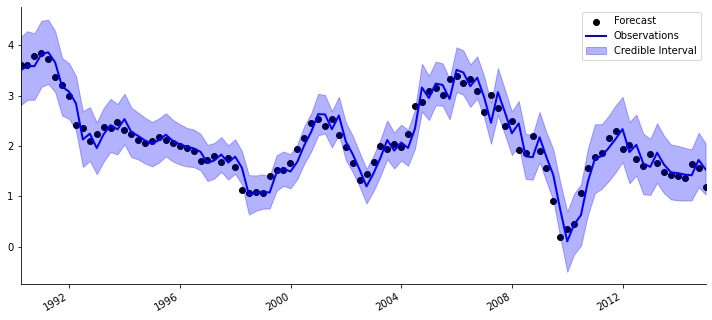

In [8]:
#And plot the 1−quarter ahead forecasts. There is a clear 'lagged' pattern in the forecasts,
#in which the forecast is close to the previous observation. This is because the previous 
#observation is a very important predictor in the 4 models that we are averaging together.
fig, ax = plt.subplots(figsize=(10,5))
plot_data_forecast(fig, ax,
                   Y[forecast_start:forecast_end+1],
                   forecast, samples,
                   dates[forecast_start:forecast_end+1],
                   linewidth = 2)

<AxesSubplot:>

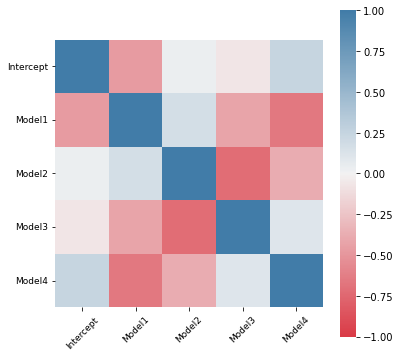

In [9]:
#We can also look at the correlation matrix of our coefficients, telling us which ones are 
#positively and negatively correlated. Typically, highly correlated variables have negatively 
#correlated coefficients.
D = np.sqrt(mod.R.diagonal()).reshape(-1,1)
corr = mod.R/D/D.T
fig, ax = plt.subplots(figsize=(6,6))
plot_corr(fig, ax, corr=corr, labels = ['Intercept', 'Model1', 'Model2', 'Model3', 'Model4'])